<h1> ECE4179 - Semi-Supervised Learning Project</h1>
<h2>FixMatch</h2>

In [1]:
import torch
from torchvision.datasets import STL10 as STL10
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.optim as optim
from randaugment import RandAugmentMC
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
import os
import time
import copy

# For rotation
from PIL import Image
from typing import Any, Callable, Optional, Tuple

#Logging
os.environ["WANDB_SILENT"] = "true"
import wandb
wandb.login()

####### CHANGE TO APPROPRIATE DIRECTORY TO STORE DATASET
dataset_dir = os.getcwd()+"/CNN-VAE/data"
#For MonARCH
# dataset_dir = "/mnt/lustre/projects/ds19/SHARED"


In [2]:
#All images are 3x96x96
image_size = 96
#Example batch size
batch_size = 24
# Number of classes for classification
out_classes = 10

#temp = 0.5 Pseudo label temperature
mu = 20 #Coefficient of unlabelled batch size
threshold = 0.75 #Pseudo label threshold
lambda_u = 8  #Coefficient of unlabelled loss

start_from_checkpoint = False
save_dir = 'Models'
model_name = 'FixMatch'
    
# Hardware acceleration
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')

<h3>Create the appropriate transforms</h3>

In [3]:
#Perform random crops and mirroring for data augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(image_size, padding=12, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomAffine(10, translate=(0.1,0.1)),
    #RandAugmentMC(n=1, m=3),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

#No random 
transform_test = transforms.Compose([
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

stl10_mean = (0.485, 0.456, 0.406)
stl10_std = (0.229, 0.224, 0.225)


class TransformFix(object):
    def __init__(self, mean, std):
        self.weak = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(size=96,
                                  padding=int(96*0.125),
                                  padding_mode='reflect')])
        self.strong = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(size=96,
                                  padding=int(96*0.125),
                                  padding_mode='reflect'),
            RandAugmentMC(n=20, m=10, cutout=23)])
        self.normalize = transforms.Compose([
            transforms.ToTensor(),
            #transforms.Normalize(mean=mean, std=std)
            ])

    def __call__(self, x):
        weak = self.weak(x)
        strong = self.strong(x)
        return self.normalize(weak), self.normalize(strong)

<h3>Create training and validation split</h3>

In [4]:
#Load train and validation sets
trainval_set = STL10(dataset_dir, split='train', transform=transform_train, download=True)
#Use 10% of data for training - simulating low data scenario
num_train = int(len(trainval_set)*0.1)
#Split data into train/val sets
torch.manual_seed(0) #Set torch's random seed so that random split of data is reproducible
train_set, val_set = random_split(trainval_set, [num_train, len(trainval_set)-num_train])

test_set = STL10(dataset_dir, split='test', transform=transform_test, download=True)

unlabelled_set = STL10(dataset_dir, split='unlabeled', transform=TransformFix(mean=stl10_mean, std=stl10_std), download=True)

class_labels = ["airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"]
print("Train: {} Val: {} Test: {}".format(len(train_set),len(val_set),len(test_set)))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Train: 500 Val: 4500 Test: 8000


<h3>Create the four dataloaders</h3>

In [5]:
num_workers = 2
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size, drop_last=True, num_workers=num_workers, pin_memory=True, persistent_workers=True)
unlabelled_loader = DataLoader(unlabelled_set, shuffle=True, batch_size=int(batch_size*mu), pin_memory=True, drop_last=True)#, persistent_workers=True)#, num_workers=4, persistent_workers=True)

valid_loader = DataLoader(val_set, batch_size=batch_size, drop_last=True, num_workers=num_workers, pin_memory=True, persistent_workers=True)
test_loader  = DataLoader(test_set, batch_size=batch_size, drop_last=True, num_workers=num_workers, pin_memory=True, persistent_workers=True)

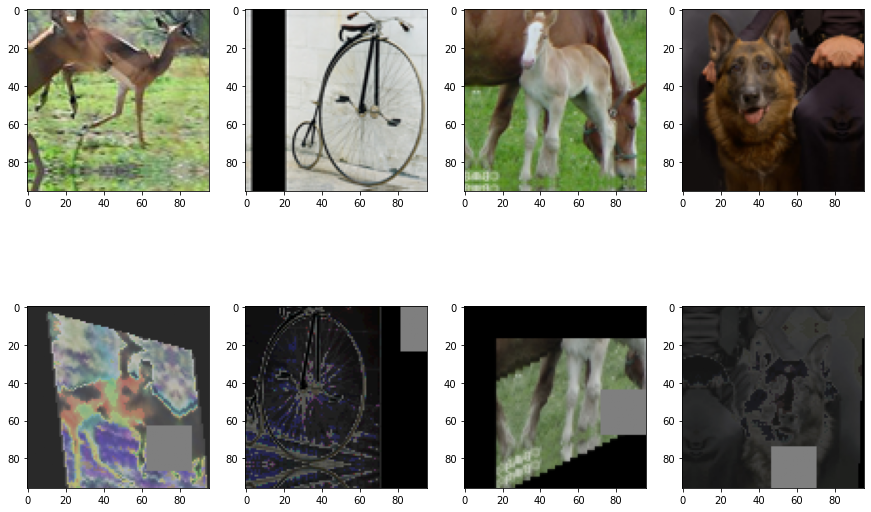

In [6]:
labeled_iter = iter(train_loader)
unlabeled_iter = iter(unlabelled_loader)

# #This Function will allow us to scale an images pixel values to a value between 0 and 1
# def normalize_img(img):
#     mins = img.min(0, keepdims = True).min(1, keepdims = True)
#     maxs = img.max(0, keepdims = True).max(1, keepdims = True)
#     return (img - mins)/(maxs - mins)

#Visualise strongly augmented unlabeled images
plt.figure(figsize = (15,10))
(image_batch_w, image_batch_s),_ = unlabeled_iter.next()
for i in range(4):    
    img_s = np.moveaxis(image_batch_s[i].numpy(),0,2)
    img_w = np.moveaxis(image_batch_w[i].numpy(),0,2)
    plt.subplot(2,4,i+1)
    plt.imshow(img_w)
    plt.subplot(2,4,i+5)
    plt.imshow(img_s)

In [7]:
def calculate_accuracy(fx, y):
    preds = fx.max(1, keepdim=True)[1]
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float()/preds.shape[0]
    return acc

In [8]:
def interleave(x, size):
    s = list(x.shape)
    return x.reshape([-1, size] + s[1:]).transpose(0, 1).reshape([-1] + s[1:])

def de_interleave(x, size):
    s = list(x.shape)
    return x.reshape([size, -1] + s[1:]).transpose(0, 1).reshape([-1] + s[1:])


In [9]:
#Create Save Path from save_dir and model_name, we will save and load our checkpoint here
Save_Path = os.path.join(save_dir, model_name + ".pt")

#Create the save directory if it does not exist
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

#Load Checkpoint
if start_from_checkpoint:
    #Check if checkpoint exists
    if os.path.isfile(Save_Path):
        #load Checkpoint
        check_point = torch.load(Save_Path)
        #Checkpoint is saved as a python dictionary
        #https://www.w3schools.com/python/python_dictionaries.asp
        #here we unpack the dictionary to get our previous training states
        net.load_state_dict(check_point['model_state_dict'])
        optimizer.load_state_dict(check_point['optimizer_state_dict'])
        start_epoch = check_point['epoch']
        best_valid_acc = check_point['valid_acc']
        print("Checkpoint loaded, starting from epoch:", start_epoch)
    else:
        #Raise Error if it does not exist
        raise ValueError("Checkpoint Does not exist")
else:
    #If checkpoint does exist and Start_From_Checkpoint = False
    #Raise an error to prevent accidental overwriting
    if os.path.isfile(Save_Path):
        print("Warning Checkpoint exists")
    else:
        print("Starting from scratch")

Starting from scratch


In [10]:
def train(net, device, labeled_trainloader, unlabeled_trainloader, test_loader, optimizer, mu, threshold, lambda_u, epoch):
    #Train mode
    net.train()
    try:
        inputs_x, targets_x = labeled_iter.next()
    except:
        labeled_iter = iter(labeled_trainloader)
        inputs_x, targets_x = labeled_iter.next()
    try:
        (inputs_u_w, inputs_u_s),_ = unlabeled_iter.next()
    except:
        unlabeled_iter = iter(unlabeled_trainloader)
        (inputs_u_w, inputs_u_s),_ = unlabeled_iter.next()

    batch_size = inputs_x.shape[0]
    inputs_u_w = torch.FloatTensor(inputs_u_w)
    inputs_u_s = torch.FloatTensor(inputs_u_s)
    inputs = interleave(torch.cat((inputs_x, inputs_u_w, inputs_u_s)), 2*mu+1).to(device)
    # test = torch.cat((inputs_x, inputs_u_w, inputs_u_s))
    # plt.figure(figsize = (20,10))
    # for i in np.linspace(0,120,11, dtype=int).tolist():    
    #     img = np.moveaxis(test[i].numpy(),0,2)
    #     plt.subplot(3,5,(i//12)+1)
    #     plt.imshow(img)
    targets_x = targets_x.to(device)
    logits = net(inputs)
    logits = de_interleave(logits, 2*mu+1)
    logits_x = logits[:batch_size]
    logits_u_w, logits_u_s = logits[batch_size:].chunk(2)
    del logits

    Lx = F.cross_entropy(logits_x, targets_x, reduction='mean')

    pseudo_label = torch.softmax(logits_u_w.detach(), dim=-1)
    max_probs, targets_u = torch.max(pseudo_label, dim=-1)
    mask = max_probs.ge(threshold).float()
    Lu = (F.cross_entropy(logits_u_s, targets_u, reduction='none') * mask).mean()
    #Compute total loss
    loss = Lx + lambda_u * Lu
    #calc acc
    acc = calculate_accuracy(logits_x, targets_x)
    #zero gradients
    optimizer.zero_grad()
    #Backpropagate Gradents
    loss.backward()
    #Do a single optimization step
    optimizer.step()
    #log the loss and acc for plotting
    wandb.log({"Training": {"Loss" : loss.item(), "Acc" : acc.item()}}, step=epoch)
    wandb.log({"Training": {"Lx" : Lx.item(), "Lu" : Lu.item()*2}}, step=epoch)
    wandb.log({"Pseudo label count": torch.sum(mask).cpu().numpy()}, step=epoch)

    return Lx.item(), Lu.item()

In [11]:
def evaluate(net, device, loader, loss_fn):
    epoch_loss = 0
    epoch_acc = 0
    #Set network in evaluation mode
    net.eval()
    
    for i, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)
        #Forward pass
        fx = net(x)
        #Calculate loss
        loss = loss_fn(fx, y.type(torch.LongTensor).to(device))
        #calculate the accuracy
        acc = calculate_accuracy(fx, y)
        #log the cumulative sum of the loss and acc
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        #Validation set too large, stop at 20 batches
        if i==40:
            break

    return epoch_loss/i, epoch_acc/i

In [12]:
start_epoch = 0
n_epochs = 6000
lr = 5e-4

net = torchvision.models.resnet18(pretrained=False).to(device)
net_fc_in = net.fc.in_features
net.fc = nn.Linear(net_fc_in, out_classes).to(device)
optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=4e-2)
#optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=5e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=1, epochs=n_epochs, div_factor=4, pct_start=0.15, three_phase=True, final_div_factor=1e5)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5)
loss_fn = nn.CrossEntropyLoss()
with wandb.init(project="Semi-supervised Learning", group='fixmatch', job_type='train', reinit=True, mode='online'):
    for epoch in range(start_epoch, n_epochs):
        if epoch==300:
            threshold = 0.80
        elif epoch==500:
            threshold = 0.85
        elif epoch==1000:
            threshold = 0.90
        elif epoch==1500:
            threshold = 0.95
        Lx, Lu = train(net=net, device=device, labeled_trainloader=train_loader, unlabeled_trainloader=unlabelled_loader, test_loader=test_loader, optimizer=optimizer, mu=mu, threshold=threshold, lambda_u=lambda_u, epoch=epoch)
        
        scheduler.step()
        if epoch%30==0:
            valid_loss, valid_acc = evaluate(net, device, valid_loader, loss_fn)
            wandb.log({"Validation": {"Loss" : valid_loss, "Acc" : valid_acc}}, step=epoch)
        wandb.log({"Learning Rate" : scheduler.get_last_lr()[0]}, step=epoch)

C:\Users\zarre\.conda\envs\gpu\lib\site-packages\IPython\html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:76] data. DefaultCPUAllocator: not enough memory: you tried to allocate 108822528 bytes.